In [17]:
from tqdm import tqdm
import sys 
sys.path.append("..")

from src.models.neural_optimal_transport import EgNOTWithEntNOT

from src.utils import get_reshape_to_pic_fn, energy_distance_np, cond_sample_in_chunks, save_pics_grid, pca_plot

from nip import load, parse, construct


In [2]:

config_path = 'egnot_entnot_cifar.yaml'

parsed_config = parse(config_path)


## Create Sampler

In [15]:
from src.samplers.one_dist_samplers import JoinOneDistSamplers, GaussianDist, TwoMoons

sampler = JoinOneDistSamplers(GaussianDist(dim=2), TwoMoons())

sampler_x = sampler.x_sample
sampler_y = sampler.y_sample


In [4]:
sampler.x_sample(batch_size).shape, sampler.y_sample(batch_size).shape

(torch.Size([128, 2]), torch.Size([128, 2]))

## Hyperparameters

In [28]:


max_iter = 10000
val_freq = 500
save_freq = 10000
batch_size = 128

device = 'cuda'

eta = 1e-4
eps = 1


## Create OT model

In [29]:

from src.models.neural_optimal_transport import EgNOT
from src.neural_networks.net import MLP_v1

f_net = MLP_v1(in_channels=2, out_channels=2, hidden_channels=128, num_hidden_blocks=2)

model = EgNOT(f_net, eps, lr=1e-4)
model.to(device)


EgNOT(
  (f_net): MLP_v1(
    (in_layer): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): SiLU()
    )
    (hidden_blocks): ModuleList(
      (0-1): 2 x Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): SiLU()
      )
    )
    (out_layer): Linear(in_features=128, out_features=2, bias=True)
  )
)

## Train it

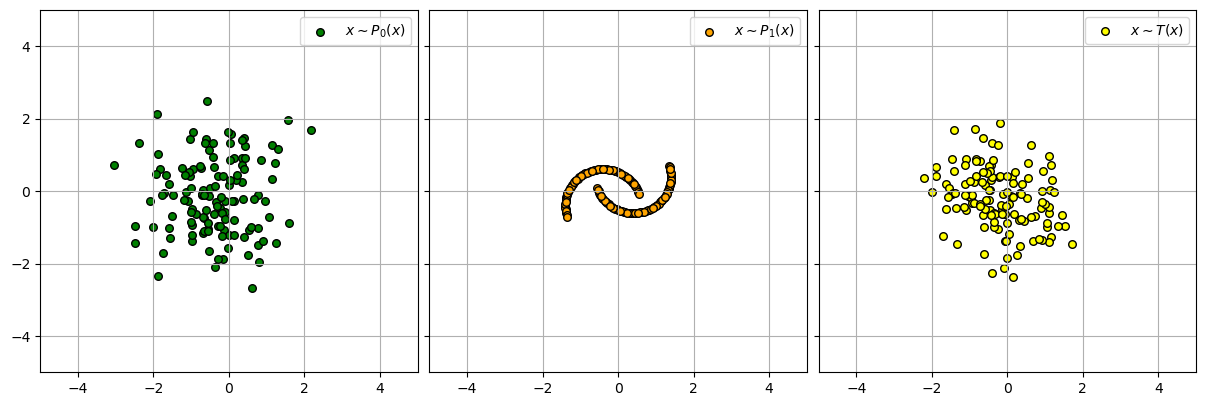

In [30]:

x_samples = sampler_x(batch_size)
y_samples = sampler_y(batch_size)

x_pred = model(x_samples.to(device)).cpu()
pca_plot(x_samples.reshape([x_samples.shape[0], -1]), y_samples.reshape([y_samples.shape[0], -1]), x_pred.reshape([x_pred.shape[0], -1]), 512, save_name='Gaussian_TwoMoons.png', is_wandb=False)


In [ ]:

for i in tqdm(range(1, max_iter + 1)):
    model.train_step(sampler_x, sampler_y, ula_steps=100, eta=eta, batch_size=batch_size)

    if i % val_freq == 0:
        print('Validation..')

        ula_steps_list = [200]

        for n_ula_steps in ula_steps_list:
            # print('ULA steps: ', n_ula_steps)
            egnot_cond_sampler_fn = lambda x: model.sample(x, ula_steps=n_ula_steps, eta=eta)
            x_pred = model.sample(x_samples.to(device), ula_steps=n_ula_steps, eta=eta)
            
            pca_plot(x_samples.reshape([x_samples.shape[0], -1]), y_samples.reshape([y_samples.shape[0], -1]), x_pred.reshape([x_pred.shape[0], -1]), 512, save_name=f'Gaussian_TwoMoons_{i}.png', is_wandb=False)
        
    if i % save_freq == 0:
        print('Saving model..')
        torch.save(model.egNOT.state_dict(), f'ckpts/EgNOT_Gaussain_TwoMoons.pth')


  5%|███▏                                                           | 499/10000 [00:47<15:03, 10.51it/s]

Validation..


 10%|██████▎                                                        | 999/10000 [01:36<14:14, 10.53it/s]

Validation..


 15%|█████████▎                                                    | 1499/10000 [02:24<13:35, 10.42it/s]

Validation..


 20%|████████████▍                                                 | 1998/10000 [03:15<12:53, 10.35it/s]

Validation..


 25%|███████████████▍                                              | 2498/10000 [04:04<11:53, 10.52it/s]

Validation..


 30%|██████████████████▌                                           | 2998/10000 [04:53<11:04, 10.54it/s]

Validation..


 32%|████████████████████                                          | 3241/10000 [05:16<10:45, 10.47it/s]